---
<div style="background-color:white; text-align:center; padding:20px;">
    <h2 style="color:black; font-family: Verdana, sans-serif;"><strong>Berenklauw classificatie</strong></h2>
    <p style="font-size: 14px; color: black; font-family: Verdana, sans-serif;"> 
        <table style="margin: auto; border-collapse: collapse;">
            <tr>
                <th style="border: 0;">Teamleden</th>
                <th style="border: 0;">GitHub Username</th>
            </tr>
            <tr>
                <td style="border: 0;">Vince Ammerlaan</td>
                <td style="border: 0;">Vince16270</td>
            </tr>
            <tr>
                <td style="border: 0;">Tommi Lander</td>
                <td style="border: 0;">tommi7</td>
            </tr>
            <tr>
                <td style="border: 0;">Nima Ghafar</td>
                <td style="border: 0;">NimaGhafar</td>
            </tr>
        </table>
    </p>
</div>

<div style="display: flex; justify-content: center; align-items: center; margin-top:20px;">
    <img src="https://www.hpg-hoveniers.nl/wp-content/uploads/2015/06/berenklauw-bestrijden-1024x768.jpg" alt="genres" style="max-width: 100%; max-height: 100%;">
</div>

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Table of contents </strong></h2>
</div>
<ul style="padding: 0; list-style: none;">
    <li style="text-align: center;"><a href="#1.0">Chapter 1: Packages, data en zelfgedefineerde functie's inladen</a></li>
    <li style="text-align: center;"><a href="#2.0">Chapter 2: Exploratory Data Analysis</a></li>
    <li style="text-align: center;"><a href="#3.0">Chapter 3: Model</a></li>
    <li style="text-align: center;"><a href="#5.0">Chapter 4: Model evaluatie</a></li>
    <li style="text-align: center;"><a href="#6.0">Chapter 5: Eigen data uittesten</a></li>
    <li style="text-align: center;"><a href="#7.0">Chapter 6: API voor MRR</a></li>
    <li style="text-align: center;"><a href="#8.0">Chapter 7: Bronnenlijst</a></li>
</ul>

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 1: Packages, data en zelfgedefineerde functie's inladen </strong></h2>
</div>

### Packages inladen

In [1]:
import os
import cv2
import PIL
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
from skimage.color import rgb2gray
from IPython.display import clear_output
from tensorflow.keras.applications import ResNet50
import matplotlib.colors as mcolors
from tensorflow.keras.models import Model
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Input
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import concatenate, UpSampling2D, BatchNormalization

### Zelfgedefineerde functie's inladen

In [2]:
sns.set_theme(style="whitegrid")

def plot_loss(history):
    """
    Deze functie laat twee grafieken zien. De eerste toont de loss tijdens training en validatie over de epochs. 
    De tweede toont de IoU tijdens training en validatie over de epochs.

    Parameters:
        history: Dit is het object dat wordt teruggegeven door de `fit` methode van een Keras model.

    Returns:
        None
    """
    plt.figure(figsize=(18, 6))
    plt.subplots_adjust(wspace=0.3)
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='#1f77b4', linestyle='-', linewidth=2, alpha=0.8)
    plt.plot(history.history['val_loss'], label='Validation Loss', color='#ff7f0e', linestyle='--', linewidth=2, alpha=0.8)
    plt.title('Training and Validation Losses', fontdict={'fontsize': 18, 'fontweight': 'bold', 'color': '#333333'})
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.5)
    plt.fill_between(range(len(history.history['loss'])), history.history['loss'], history.history['val_loss'], color='lightgray', alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['IoU'], label='Training IoU', color='#1f77b4', linestyle='-', linewidth=2, alpha=0.8)
    plt.plot(history.history['val_IoU'], label='Validation IoU', color='#ff7f0e', linestyle='--', linewidth=2, alpha=0.8)
    plt.title('Training and Validation IoU', fontdict={'fontsize': 18, 'fontweight': 'bold', 'color': '#333333'})
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('IoU', fontsize=14)
    plt.legend(fontsize=12, loc='lower right')
    plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.5)
    plt.fill_between(range(len(history.history['IoU'])), history.history['IoU'], history.history['val_IoU'], color='lightgray', alpha=0.3)

    plt.tight_layout()
    plt.show()

In [3]:
# Functie om maskers voor te verwerken om binaire waarden te garanderen
def preprocess_mask(mask):
    mask = np.where(mask > 0, 1, 0).astype(np.uint8)
    return mask

In [4]:
# Functie om pixels met 1 of 0 te tellen
def count_pixels(mask):
    unique, counts = np.unique(mask, return_counts=True)
    pixel_count = dict(zip(unique, counts))
    return pixel_count

In [5]:
# Functie om afbeeldingen weer te geven
def display_images(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [6]:
# Drempel toepassen op voorspelde maskers voor binaire segmentatie
def threshold_predictions(predictions, threshold=0.5):
    return (predictions > threshold).astype(np.uint8)

In [7]:
def batch_generator(image_folder, mask_folder, batch_size):
    image_files = os.listdir(image_folder)
    mask_files = os.listdir(mask_folder)
    while True:
        batch_images = []
        batch_masks = []
        for i in range(batch_size):
            img_file = image_files[i % len(image_files)]
            mask_file = mask_files[i % len(mask_files)]
            
            img_path = os.path.join(image_folder, img_file)
            mask_path = os.path.join(mask_folder, mask_file)
            
            image = load_img(img_path, target_size=(256, 256))
            mask = load_img(mask_path, target_size=(256, 256), color_mode="grayscale")
            
            image = img_to_array(image) / 255.0
            mask = img_to_array(mask)
            mask = preprocess_mask(mask)
            
            batch_images.append(image)
            batch_masks.append(mask)
        
        yield np.array(batch_images), np.array(batch_masks)

In [14]:
def IoU(y_true, y_pred):
    """
    Bereken de Intersection over Union (IoU) voor binaire classificatietaken.

    Parameters:
        y_true (tf.Tensor): De ware labels van de gegevens. Moet een tensor zijn van vorm [batch_size, height, width, 1] of [batch_size, height, width] met binaire waarden (0 of 1).
        y_pred (tf.Tensor): De voorspelde labels van het model. Moet een tensor zijn van vorm [batch_size, height, width, num_classes] met logits of kansen voor elke klasse.

    Returns:
        float: De gemiddelde Intersection over Union (IoU) over de gegeven batch.
    """
    if y_true.shape[-1] == 1:
        y_true = tf.squeeze(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)
    intersection = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
    union = tf.reduce_sum(tf.cast(tf.logical_or(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
    iou = intersection / (union + tf.keras.backend.epsilon())  
    return iou

#### Hier knippen we de data op in allemaal kleine afbeeldingen van 256x256, zodat we meer data beschikbaar hebben en de foto's niet te groot zijn om inteladen

```python

def split_and_save_images(image_dir, output_dir, patch_size=256):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    file_names = os.listdir(image_dir)

    for file_name in file_names:
        image_path = os.path.join(image_dir, file_name)
        if os.path.isfile(image_path):
            image = Image.open(image_path)
            width, height = image.size

            num_patches_x = width // patch_size
            num_patches_y = height // patch_size

            for i in range(num_patches_x):
                for j in range(num_patches_y):
                    left = i * patch_size
                    upper = j * patch_size
                    right = (i + 1) * patch_size
                    lower = (j + 1) * patch_size
                    
                    patch = image.crop((left, upper, right, lower))
                    patch_name = f"{file_name.split('.')[0]}_patch_{i}_{j}.jpg"
                    patch.save(os.path.join(output_dir, patch_name))

image_dir = 'eigen masks/images'
output_dir = 'eigen masks/image_patches'
split_and_save_images(image_dir, output_dir)

mask_dir = 'eigen masks/masks'
output_dir = 'eigen masks/mask_patches'
split_and_save_images(mask_dir, output_dir)

### Afbeeldingen en masks inladen

Total images: 8802
Steps per epoch: 137
Validation steps: 27.0


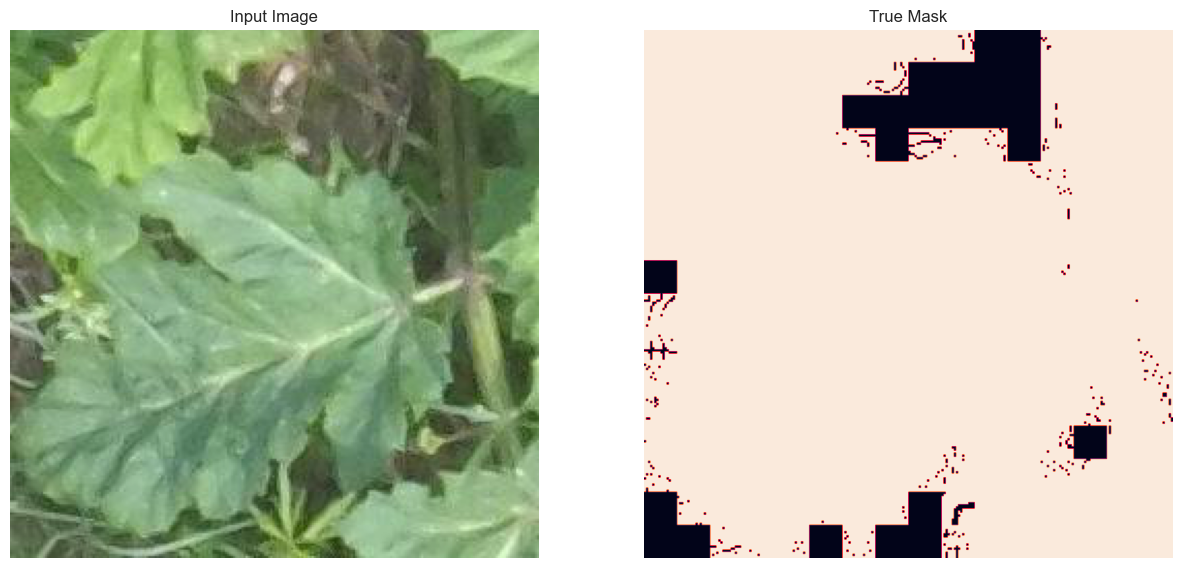

In [ ]:
image_folder = 'zelf gelabelde data/image_patches'
mask_folder = 'zelf gelabelde data/mask_patches'

batch_size = 1024
generator = batch_generator(image_folder, mask_folder, batch_size=batch_size)

batch_images, batch_masks = next(generator)
train_images, test_images, train_masks, test_masks = train_test_split(batch_images, batch_masks, test_size=0.2, random_state=42)

sample_image, sample_mask = train_images[39], train_masks[39]
display_list = [sample_image, sample_mask]
display_images(display_list)

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 2: Exploratory Data Analysis </strong></h2>
</div>

In [10]:
num_images_without_masks = sum(np.all(mask == 0) for mask in train_masks)
percentage_without_masks = num_images_without_masks / len(train_masks) * 100

print(f"Aantal afbeeldingen in de dataset: {len(train_masks)}")
print(f"Aantal afbeeldingen met maskers: {len(train_masks) - num_images_without_masks}")
print(f"Aantal afbeeldingen zonder maskers: {num_images_without_masks}")
print(f"Percentage afbeeldingen met maskers: {100 - round(percentage_without_masks, 2)}%")
print(f"Percentage afbeeldingen zonder maskers: {round(percentage_without_masks, 2)}%")

Aantal afbeeldingen in de dataset: 51
Aantal afbeeldingen met maskers: 17
Aantal afbeeldingen zonder maskers: 34
Percentage afbeeldingen met maskers: 33.33%
Percentage afbeeldingen zonder maskers: 66.67%


In [ ]:
print(f"Afbeelding lengte en breedte: {images[0].shape}")

In [10]:
data = []

for i in range(len(images)):
    height, width, channels = images[i].shape
    size = height * width
    has_mask = np.any(masks[i])
    mask_coverage = np.sum(masks[i]) / size
    aspect_ratio = width / height
    avg_color = np.mean(images[i], axis=(0, 1)) / 255  
    avg_color_hex = mcolors.rgb2hex(avg_color)
    
    color_std = np.std(images[i], axis=(0, 1)) / 255
    brightness = np.mean(images[i]) / 255
    gray_image = rgb2gray(images[i])
    contrast = np.std(gray_image)

    data.append([i, width, height, size, has_mask, mask_coverage, avg_color, avg_color_hex, color_std, brightness, contrast])

images_info = pd.DataFrame(data, columns=['image_id', 'Breedte', 'Hoogte', 'Grootte'
                                          , 'Heeft een mask', 'Mask bedekking', 'Verdeling kleuren'
                                          , 'Gemiddelde kleur HTML', 'Kleurvariatie', 'Helderheid'
                                          , 'Contrast'])

images_info.head(10)

/Users/vince/tensorflow-env/tensorflow/lib/python3.8/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


,image_id,Breedte,Hoogte,Grootte,Heeft een mask,Mask bedekking,Verdeling kleuren,Gemiddelde kleur HTML,Kleurvariatie,Helderheid,Contrast,Scherpte,Textuur
0,0,256,256,65536,False,0.000000,"[0.31791592, 0.31339458, 0.21003519]",#515036,"[0.13426706, 0.11359309, 0.117681906]",0.280449,29.927988,12.145498,128.511795
1,1,256,256,65536,False,0.000000,"[0.25132805, 0.26112098, 0.16644251]",#40432a,"[0.15120314, 0.12940283, 0.12614173]",0.226297,33.876801,12.580442,129.611420
2,2,256,256,65536,False,0.000000,"[0.33429098, 0.30934393, 0.21817777]",#554f38,"[0.11453727, 0.10511051, 0.10453343]",0.287271,27.097288,11.143960,128.122177
3,3,256,256,65536,False,0.000000,"[0.26403874, 0.26159608, 0.17063037]",#43432c,"[0.12875098, 0.113046475, 0.10917901]",0.232088,29.416195,13.168421,129.983215
4,4,256,256,65536,True,0.099258,"[0.351229, 0.3669547, 0.2169576]",#5a5e37,"[0.16704808, 0.14910875, 0.15556611]",0.311714,38.115334,17.155096,127.542786
5,5,256,256,65536,True,0.649506,"[0.23869151, 0.31296858, 0.11578357]",#3d501e,"[0.15379989, 0.1728394, 0.114877895]",0.222481,40.670506,19.429577,129.339066
6,6,256,256,65536,True,0.034912,"[0.27795225, 0.29750127, 0.1693278]",#474c2b,"[0.14493911, 0.12594269, 0.12621263]",0.248260,32.253376,13.987013,129.227386
7,7,256,256,65536,True,0.415085,"[0.23269606, 0.28785586, 0.13158509]",#3b4922,"[0.15210676, 0.15874833, 0.12191309]",0.217379,38.204552,18.302040,130.233994
8,8,256,256,65536,True,0.030685,"[0.3049412, 0.33943787, 0.21859999]",#4e5738,"[0.1403707, 0.12977038, 0.13442725]",0.287660,33.036785,15.735457,128.283554
9,9,256,256,65536,True,0.167160,"[0.2320763, 0.30297655, 0.14998941]",#3b4d26,"[0.14340785, 0.14832604, 0.12833008]",0.228347,36.310074,17.685556,130.418015


 1.⁠ ⁠⁠ image_id ⁠: Dit is een unieke identificatie voor elke afbeelding in de dataset. In dit geval is het de index van de afbeelding in de lijst ⁠ images ⁠. Bijvoorbeeld, ⁠ 0 ⁠ betekent dat dit de eerste afbeelding in de lijst is. Het is belangrijk om elke afbeelding te kunnen identificeren, vooral als je later naar specifieke afbeeldingen wilt verwijzen.

 2.⁠ ⁠⁠ Breedte ⁠: Dit is de breedte van de afbeelding in pixels. In dit geval is de breedte ⁠ 224 ⁠ pixels. Het kennen van de afmetingen van de afbeelding kan nuttig zijn bij het analyseren van de afbeelding, bijvoorbeeld om te begrijpen hoe de grootte van de afbeelding de maskerdekking beïnvloedt.

 3.⁠ ⁠⁠ Hoogte ⁠: Dit is de hoogte van de afbeelding in pixels. In dit geval is de hoogte ⁠ 224 ⁠ pixels. Net als de breedte kan de hoogte nuttig zijn bij het analyseren van de afbeelding.

 4.⁠ ⁠⁠ Grootte ⁠: Dit is het totale aantal pixels in de afbeelding, berekend als breedte x hoogte. In dit geval is de grootte ⁠ 50176 ⁠ pixels. Dit kan nuttig zijn bij het analyseren van de afbeelding, bijvoorbeeld om te begrijpen hoe de grootte van de afbeelding de maskerdekking beïnvloedt.

 5.⁠ ⁠⁠ Heeft een mask ⁠: Dit geeft aan of de afbeelding een bijbehorend masker heeft. In dit geval heeft de afbeelding geen masker (⁠ False ⁠). Dit kan nuttig zijn bij het analyseren van de afbeelding, bijvoorbeeld om te begrijpen hoe de aanwezigheid van een masker de andere kenmerken van de afbeelding beïnvloedt.

 6.⁠ ⁠⁠ Mask bedekking ⁠: Dit is het percentage van de afbeelding dat wordt bedekt door het masker, berekend als het aantal maskerpixels gedeeld door het totale aantal pixels. In dit geval is de maskerdekking ⁠ 0.000000 ⁠, wat betekent dat er geen masker is. Dit kan nuttig zijn bij het analyseren van de afbeelding, bijvoorbeeld om te begrijpen hoe de maskerdekking de andere kenmerken van de afbeelding beïnvloedt.

 7.⁠ ⁠⁠ Verdeling kleuren ⁠: Dit is de gemiddelde kleur van de afbeelding, berekend als de gemiddelde RGB-waarde van alle pixels en genormaliseerd tussen 0 en 1. In dit geval is de gemiddelde kleur ⁠ [0.3177765, 0.31320137, 0.20988709] ⁠, wat een donkerbruine kleur is. Het kennen van de gemiddelde kleur kan nuttig zijn bij het analyseren van de afbeelding, zodat je weet hoe verschillend de kleuren zijn.

 8.⁠ ⁠⁠ Gemiddelde kleur HTML ⁠: Dit is de gemiddelde kleur van de afbeelding, omgezet naar een HTML-kleur (hexadecimale kleurcode). In dit geval is de gemiddelde kleur ⁠ #515036 ⁠, wat overeenkomt met de RGB-kleur in de 'Verdeling kleuren' kolom. Het kennen van de HTML-kleur kan nuttig zijn voor visualisatiedoeleinden, bijvoorbeeld om een overzicht van de gemiddelde kleuren van de afbeeldingen te maken.

 9.⁠ ⁠⁠ Kleurvariatie ⁠: Dit is de standaardafwijking van de kleuren in de afbeelding, berekend als de standaardafwijking van de RGB-waarden van alle pixels en genormaliseerd tussen 0 en 1. In dit geval is de kleurvariatie ⁠ [0.18607375, 0.18607375, 0.18607375] ⁠, wat betekent dat de kleuren in de afbeelding niet erg variëren. Het kennen van de kleurvariatie kan nuttig zijn bij het analyseren van de afbeelding, bijvoorbeeld om te begrijpen hoe uniform de kleuren zijn.

10.⁠ ⁠⁠ Helderheid ⁠: Dit is de gemiddelde helderheid van de afbeelding, berekend als de gemiddelde helderheid van alle pixels en genormaliseerd tussen 0 en 1. In dit geval is de helderheid ⁠ 0.31320137 ⁠, wat betekent dat de afbeelding niet erg helder is. Het kennen van de helderheid kan nuttig zijn bij het analyseren van de afbeelding, bijvoorbeeld om te begrijpen hoe licht of donker de afbeelding is.

11.⁠ ⁠⁠ Contrast ⁠: Dit is de contrastwaarde van de afbeelding, berekend als de standaardafwijking van de grijswaarden van de afbeelding. In dit geval is het contrast ⁠ 0.18607375 ⁠, wat betekent dat de afbeelding een gemiddeld contrast heeft. Het kennen van het contrast kan nuttig zijn bij het analyseren van de afbeelding, bijvoorbeeld om te begrijpen hoe scherp de overgangen tussen lichte en donkere delen zijn.

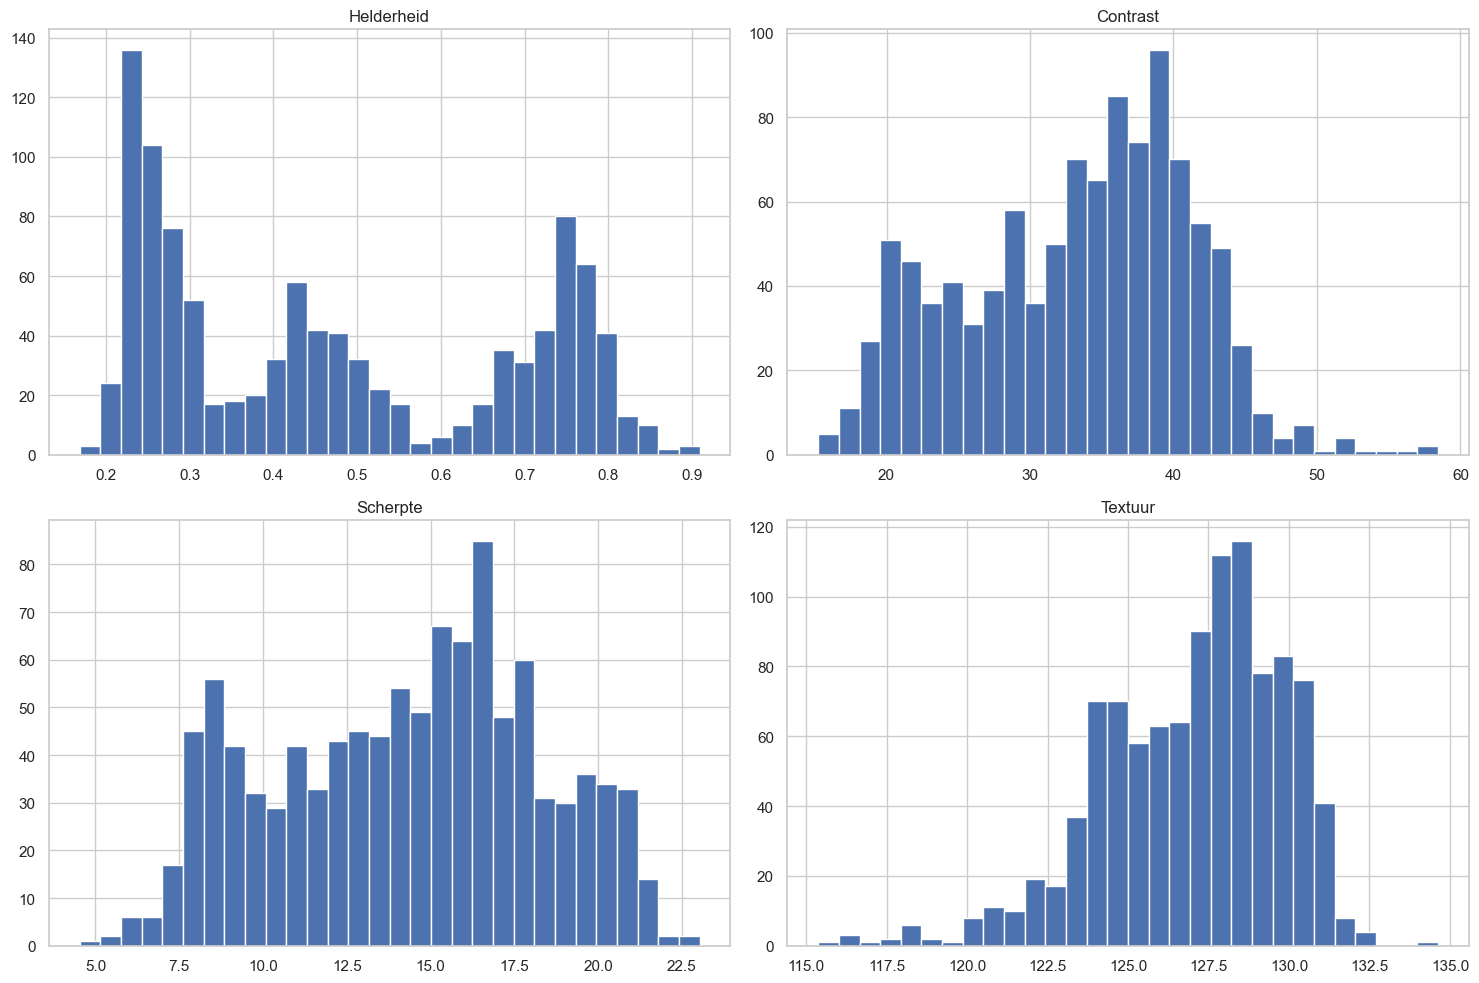

In [11]:
images_info[['Kleurvariatie', 'Helderheid', 'Contrast']].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

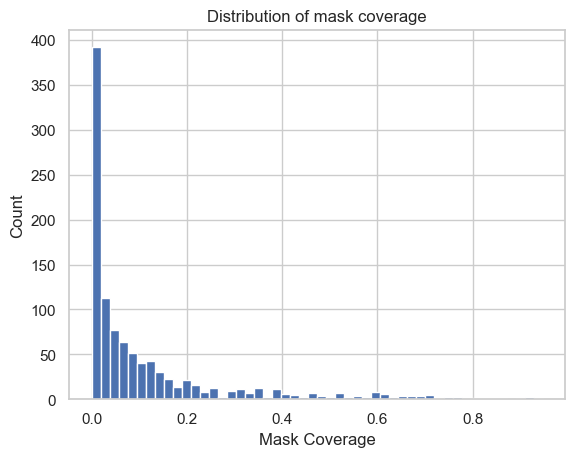

In [12]:
plt.hist(images_info['Mask bedekking'], bins=50)
plt.xlabel('Mask Coverage')
plt.ylabel('Count')
plt.title('Distribution of mask coverage')
plt.show()

We zien dat er veel afbeeldingen zijn zonder of weinig maskers. Dit is dan moeilijk voor het model om te leren. 
Wel is dit nodig, omdat we kunnen zien dat het model ook werkt als er geen berenklauw te zien is. 
Zoals eerder is aangegeven is 17% van de afbeeldingen zonder masker. Dit is een prima percentage om mee te werken, omdat het model ook moet leren om afbeeldingen zonder masker te herkennen meestal afbeeldingen zijn zonder berenklauwen.

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 3: Model </strong></h2>
</div>

In [11]:
width, height = 256, 256

base_model = ResNet50(include_top=False, input_shape=(width, height, 3), weights='imagenet')

layer_names = [
    'conv1_relu',
    'conv2_block3_out',
    'conv3_block4_out',
    'conv4_block6_out',
    'conv5_block3_out',
]
base_model_outputs = [base_model.get_layer(
    name).output for name in layer_names]
base_model.trainable = False

ResNet_50 = tf.keras.models.Model(base_model.input, base_model_outputs)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_20 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_19[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_20[0][0]']           
 g2D)                                                                                       

In [12]:
def fcn8_decoder(convs, n_classes):
    n = 4096

    c6 = tf.keras.layers.Conv2D(n, (7, 7), activation='relu', padding='same', name="conv6")(convs[-1])
    c7 = tf.keras.layers.Conv2D(n, (1, 1), activation='relu', padding='same', name="conv7")(c6)

    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4, 4), strides=(2, 2), use_bias=False, padding='same')(c7)

    o2 = tf.keras.layers.Conv2D(n_classes, (1, 1), activation='relu', padding='same')(convs[3])
    o = tf.keras.layers.Add()([o, o2])

    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4, 4), strides=(2, 2), use_bias=False, padding='same')(o)

    o2 = tf.keras.layers.Conv2D(n_classes, (1, 1), activation='relu', padding='same')(convs[2])
    o = tf.keras.layers.Add()([o, o2])

    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(16, 16), strides=(8, 8), use_bias=False, padding='same')(o)
    o = tf.keras.layers.Activation('softmax')(o)
    return o

In [ ]:
def segmentation_model():
	inputs = keras.layers.Input(shape=(width, height, 3))
	convs = ResNet_50(inputs)
	outputs = fcn8_decoder(convs, 2) 
	model = tf.keras.Model(inputs=inputs, outputs=outputs)
	return model

opt = keras.optimizers.legacy.Adam()

model = segmentation_model()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[iou])

model.summary()

In [ ]:
BATCH_SIZE = 32
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_masks)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_masks)).batch(BATCH_SIZE)

### Model opslaan

In [20]:
#model.save('berenklauw_model.keras')

### Model inladen

In [ ]:
#new_model = tf.keras.models.load_model('berenklauw_model.h5')

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 4: Model evaluatie </strong></h2>
</div>

In [ ]:
pred_masks = model.predict(test_images)
pred_masks_thresholded = threshold_predictions(pred_masks, threshold=0.5)

for i in range(len(test_images)):
    display_images([test_images[i], test_masks[i], pred_masks_thresholded[i]])

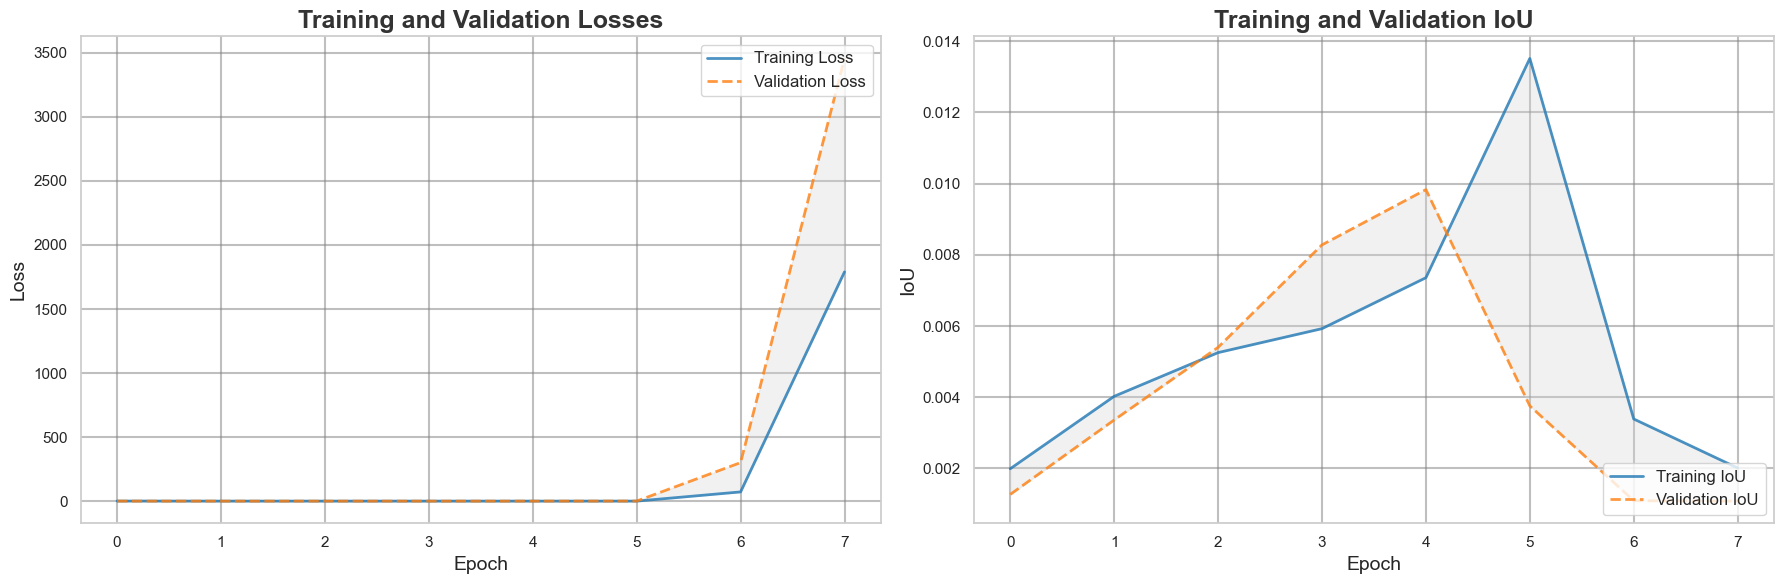

In [31]:
plot_loss(history)

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 5: Eigen data uittesten </strong></h2>
</div>

In [ ]:
def split_image(image, patch_size=256):
    patches = []
    h, w, _ = image.shape
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size, :]
            if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                pad_h = patch_size - patch.shape[0]
                pad_w = patch_size - patch.shape[1]
                patch = np.pad(patch, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')
            patches.append(patch)
    return patches

def merge_patches(patches, image_shape, patch_size=256):
    h, w, c = image_shape
    reconstructed_image = np.zeros((h, w, 1))
    patch_index = 0
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = patches[patch_index]
            patch_h, patch_w, _ = patch.shape
            reconstructed_image[i:i+patch_h, j:j+patch_w, :] = patch
            patch_index += 1
    return reconstructed_image

# Laad je eigen afbeelding
def load_single_image(image_path, target_size=(256, 256)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image) / 255.0
    return image

# Geef het pad van je eigen afbeelding
own_image_path = 'eigen data/your_image.jpg'
own_image = load_single_image(own_image_path, target_size=None)  # Load original size

# Snijd de afbeelding in stukken van 256x256
patches = split_image(own_image, patch_size=256)

# Voer voorspellingen uit voor elk stuk
patches_array = np.array(patches)
pred_patches = model.predict(patches_array)
pred_patches_thresholded = threshold_predictions(pred_patches, threshold=0.5)

# Voeg de voorspelde stukken samen tot één volledige afbeelding
reconstructed_mask = merge_patches(pred_patches_thresholded, own_image.shape, patch_size=256)

# Toon de resultaten
display_prediction_images(own_image, reconstructed_mask)

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 6: API voor MRR </strong></h2>
</div>

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 7: Bronnenlijst </strong></h2>
</div>

### EDGE DETECTION TOMMI

Preprocessed Image


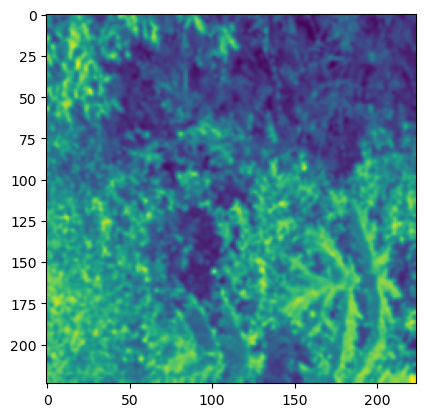

In [ ]:
def preprocess_images(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    return blurred

preprocessed_train_images = [preprocess_images(image) for image in train_images]
print(f"Preprocessed Image", )
plt.imshow(preprocessed_train_images[0])



In [ ]:
def detect_edges(image):
    image_uint8 = np.uint8(image)
    edges = cv2.Canny(image_uint8, 50, 150)
    return edges

edge_detected_train_images = [detect_edges(image) for image in preprocessed_train_images]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


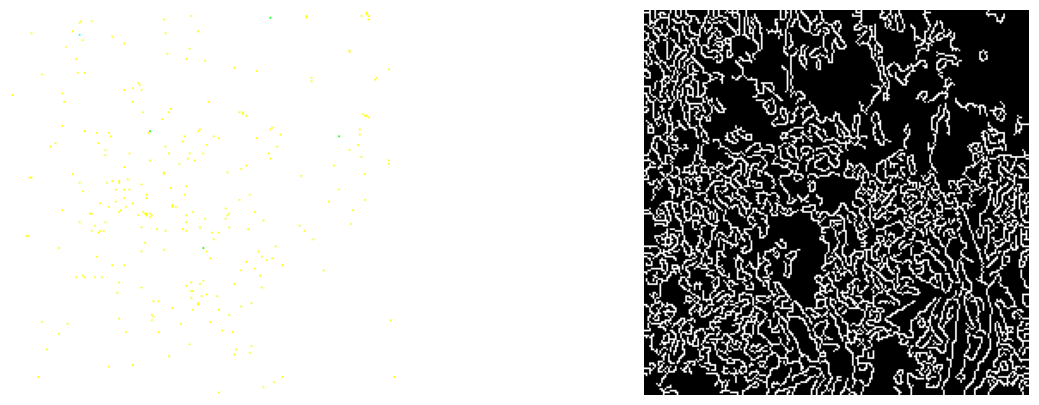

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


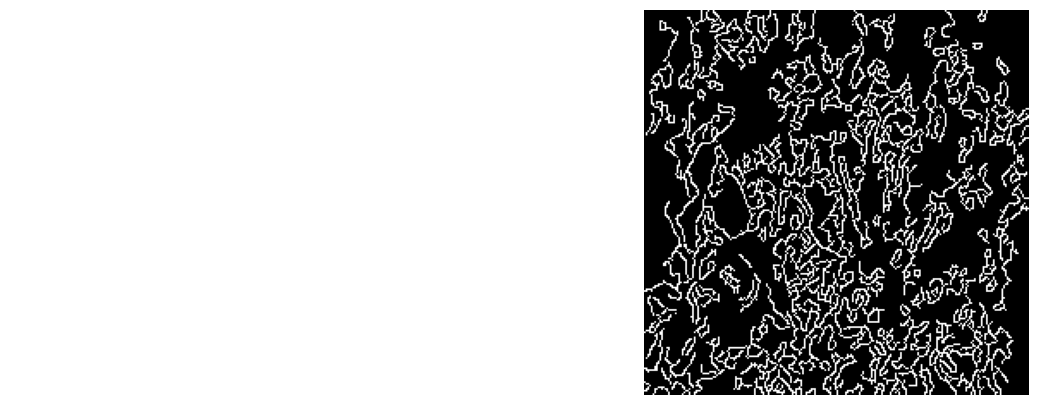

In [ ]:
def display_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, image in enumerate(images):
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
    plt.show()

for i in range(2):
    display_list = [train_images[i], edge_detected_train_images[i]]
    display_images(display_list)

In [ ]:
#het eerste plaatje laat zien waar de beurenklauw zich bevind, de 2e foto laat de randen zien die zijn gevonden door het Canny model 

### Berenklauw features

In [ ]:
def preprocess_image(image):
    if len(image.shape) == 2: 
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) 
    elif image.shape[2] == 1:  
        image = np.concatenate([image] * 3, axis=2) 
    image = Image.fromarray(image.astype('uint8'))
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)
    return input_batch

model = models.resnet50(pretrained=True)
model.eval()

def extract_features(image):
    input_batch = preprocess_image(image)
    with torch.no_grad():
        output = model(input_batch)
    features = output.squeeze().numpy()  
    return features

berenklauw_features = [extract_features(image) for image in train_images]

c:\Users\nimaa\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nimaa\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\nimaa/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:09<00:00, 11.2MB/s]


In [ ]:
#De feautre extraction is al vooraf getrained en laat alleen features van de plaatjes zoals kleur en randen van de afbeelding, 
#dit is niet optimaal voor ons probleem omdat bijvoorbeeld echt de vorm van alleen de berenklauw belangrijk is en niet van heel de afbeelding dit moeten we verder onderzoeken.

### MODEL 

In [ ]:
num_epochs = 1000
patience = 30
input_size = 100
output_size = 1


model = Sequential([
    Dense(64, activation='relu', input_shape=(input_size,)),
    Dropout(0.3),  
    Dense(64, activation='relu'),
    Dropout(0.3),  
    Dense(32, activation='relu'),
    Dense(16, activation='relu'), 
    Dense(8, activation='relu'), 
    Dense(output_size)
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

history = model.fit(train_features, train_labels,
                    validation_data=(val_features, val_labels),
                    epochs=num_epochs,
                    callbacks=[stop_early])

val_loss, val_acc = model.evaluate(val_features, val_labels)

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.4484 - loss: 4.3531 - val_accuracy: 0.6000 - val_loss: 0.6663
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5086 - loss: 2.0729 - val_accuracy: 0.5500 - val_loss: 0.6911
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4781 - loss: 1.2326 - val_accuracy: 0.5000 - val_loss: 0.7179
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4859 - loss: 1.3202 - val_accuracy: 0.6500 - val_loss: 0.6956
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5016 - loss: 0.7627 - val_accuracy: 0.5500 - val_loss: 0.6892
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4695 - loss: 1.1848 - val_accuracy: 0.5500 - val_loss: 0.6965
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5367 - loss: 0.8006 - val_accuracy: 0.5500 - val_loss: 0.7027
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5055 - loss: 0.9587 - val_accuracy: 0.5000 - v

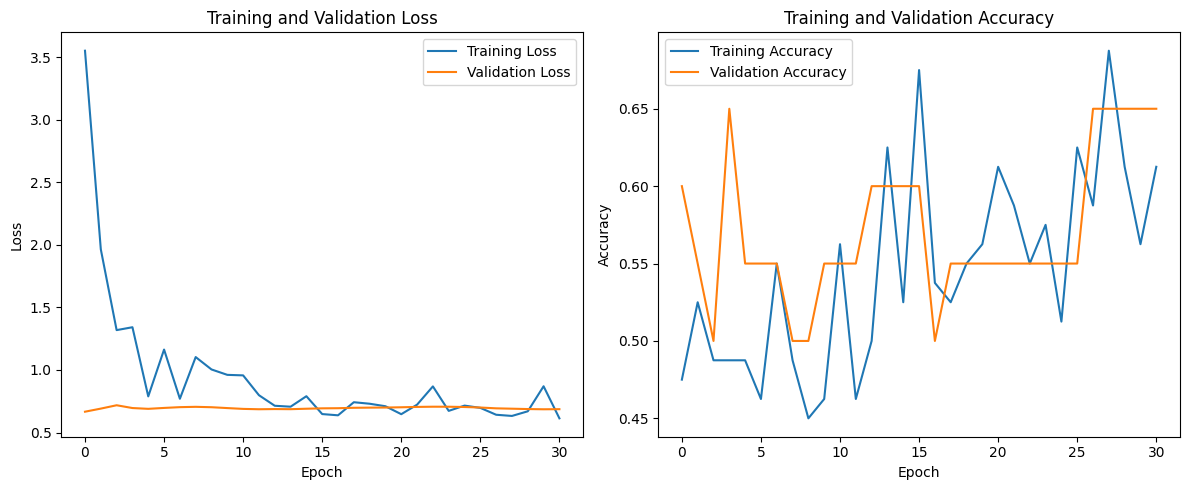

In [ ]:
plot_loss_and_accuracy(history)

## Nima Mask App
- Druk op 's' om het masker op te slaan en naar de volgende afbeelding te gaan
- Druk op 'u' om de laatste actie ongedaan te maken
- Druk op 'f' om het gebied te vullen
- Druk op '+' om de grootte van de pen te vergroten
- Druk op '-' om de grootte van de pen te verkleinen
- Zorg ervoor dat de grootte van de pen niet kleiner wordt dan 1
- Druk op 'ESC' om te stoppen zonder op te slaan
- Als 'ESC' is ingedrukt, stop dan met het verwerken van de rest van de afbeeldingen


In [99]:
import cv2
import numpy as np
import os
import glob

# De map waarin je de maskers wilt opslaan
output_dir = 'eigen_masks'

# De map waarin de afbeeldingen zijn opgeslagen
image_dir = 'image_kwadranten'

# Maak de output directory als deze nog niet bestaat
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Lijst van afbeeldingen
image_paths = glob.glob(os.path.join(image_dir, '*.jpg'))

# Variabelen om bij te houden of de muis momenteel wordt ingedrukt
drawing = False
erasing = False

# Lijst om de vorige staten van het masker op te slaan
previous_masks = []

# Lijst om de punten van het polygoon op te slaan
polygon_points = []

# De grootte van de pen
pen_size = 5


# Functie om te bellen wanneer de muis wordt gebruikt
def draw_mask(event, x, y, flags, param):
    global drawing, erasing, mask, previous_masks, polygon_points, pen_size

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        previous_masks.append(mask.copy())
        polygon_points.append((x, y))

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing == True:
            cv2.circle(mask, (x, y), pen_size, (255, 255, 255), -1)
        elif erasing == True:
            cv2.circle(mask, (x, y), pen_size, (0, 0, 0), -1)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        cv2.circle(mask, (x, y), pen_size, (255, 255, 255), -1)

    elif event == cv2.EVENT_RBUTTONDOWN:
        erasing = True
        previous_masks.append(mask.copy())

    elif event == cv2.EVENT_RBUTTONUP:
        erasing = False
        cv2.circle(mask, (x, y), pen_size, (0, 0, 0), -1)

    elif event == cv2.EVENT_LBUTTONDBLCLK:
        if len(polygon_points) > 0:
            cv2.fillPoly(mask, np.array([polygon_points], dtype=np.int32), (255, 255, 255))
            polygon_points.clear()

# Maak een venster en koppel de muisfunctie eraan
cv2.namedWindow('image', cv2.WINDOW_NORMAL)
cv2.setMouseCallback('image', draw_mask)

# Stel de grootte van het venster in
window_width = 800
window_height = 600
cv2.resizeWindow('image', window_width, window_height)

for image_path in image_paths:
    # Controleer of er al een masker bestaat voor deze afbeelding
    mask_filename = os.path.join(output_dir, os.path.basename(image_path))
    if os.path.exists(mask_filename):
        continue

    # De afbeelding waarop je het masker wilt tekenen
    image = cv2.imread(image_path)

    # Maak een leeg masker van dezelfde grootte als de afbeelding
    mask = np.zeros_like(image)

    while(1):
        cv2.imshow('image', cv2.addWeighted(image, 0.7, np.array(mask, np.uint8), 0.3, 0))
        k = cv2.waitKey(1) & 0xFF
        if k == ord('s'):  # Druk op 's' om het masker op te slaan en naar de volgende afbeelding te gaan
            cv2.imwrite(mask_filename, mask)
            break
        elif k == ord('u'):  # Druk op 'u' om de laatste actie ongedaan te maken
            if previous_masks:
                mask = previous_masks.pop()
        elif k == ord('f'):  # Druk op 'f' om het gebied te vullen
            if len(polygon_points) > 0:
                cv2.fillPoly(mask, np.array([polygon_points], dtype=np.int32), (255, 255, 255))
                polygon_points.clear()
        elif k == ord('+'):  # Druk op '+' om de grootte van de pen te vergroten
            pen_size += 1
        elif k == ord('-'):  # Druk op '-' om de grootte van de pen te verkleinen
            pen_size = max(1, pen_size - 1)  # Zorg ervoor dat de grootte van de pen niet kleiner wordt dan 1
        elif k == 27:  # Druk op 'ESC' om te stoppen zonder op te slaan
            break

    if k == 27:  # Als 'ESC' is ingedrukt, stop dan met het verwerken van de rest van de afbeeldingen
        break

cv2.destroyAllWindows()

In [ ]:
image_folder = 'image_kwadranten'
mask_folder = 'mask_kwadranten'

images, masks = load_images_and_masks(image_folder, mask_folder)

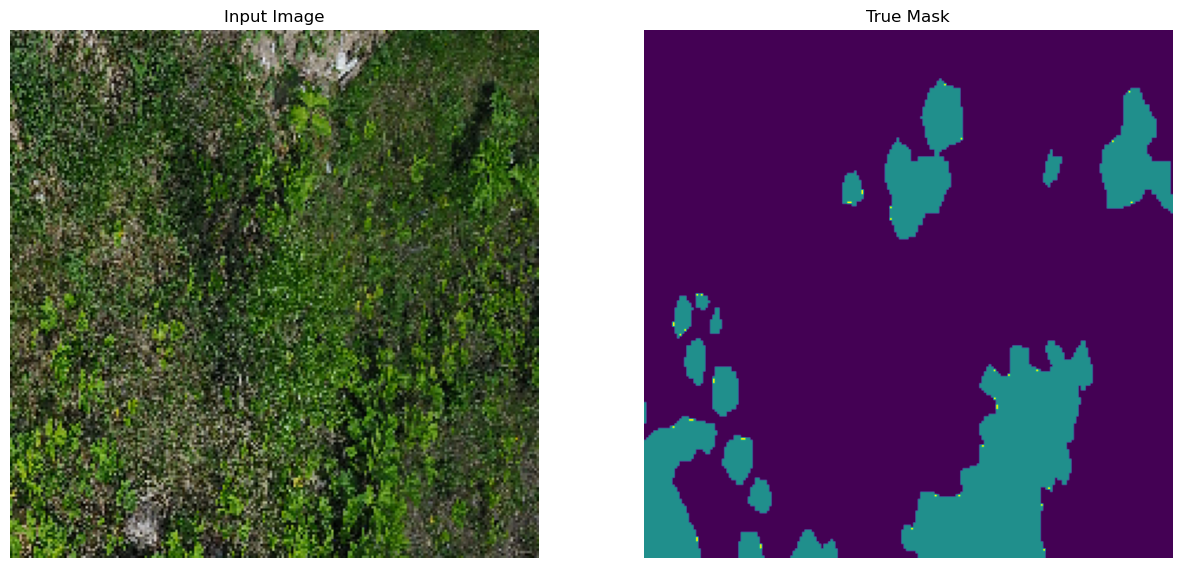

In [ ]:
#### Kijken wat de oude masks waren

sample_image, sample_mask = images[9], masks[9]
display_list = [sample_image, sample_mask]  
display_images(display_list)